## Прогнозирование операции степеней пороков сердца

Нам поставлена задача создать и выбрать лучшую модель по метрике `F1 Macro`, которая будет предсказывать одну из четырёх степеней сложности изменений в сердце(тип операции).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re

from phik import phik_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE=654321
TEST_SIZE=0.3

In [2]:
def feature_importance(importances, feature_names, top_n=20):
    """
    Функция для построения графика feature importance.

    Параметры:
    - importances: массив важности признаков
    - feature_names: массив имен признаков
    - top_n: количество первых признаков, которые нужно отобразить (по умолчанию 20)
    """
    # Создаем DataFrame для удобства отображения
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    
    # Отсортируем по важности
    feature_importance_df = feature_importance_df.sort_values(by='Importance')
    
    # Отобразим только первые top_n признаков
    feature_importance_df_top_n = feature_importance_df[-top_n:]
    
    # Построим график важности фичей
    plt.figure(figsize=(10, 10))
    plt.barh(feature_importance_df_top_n['Feature'], feature_importance_df_top_n['Importance'])
    plt.xlabel('Важность признака')
    plt.title('Влияние признаков на работу модели (Топ {})'.format(top_n), loc='left')
    plt.show()

In [3]:
def plot_distribution(data, column, ax, title=None):
    """
    Функция строит гистограмму распределения данных для указанного столбца в датафрейме.

    Параметры:
        data (pandas.DataFrame): Датафрейм, содержащий данные.
        column (str): Имя столбца, для которого требуется построить гистограмму распределения.
        title (str, по умолчанию None): Название графика. Если не указано, используется автоматически сформированное название.
        ax (matplotlib.axes._subplots.AxesSubplot): Ось для рисования графика.

    Возвращаемое значение:
        None
        Выводит на экран графики для каждого столбца.
    """
    sns.histplot(data[column].dropna(), kde=True, ax=ax)
    ax.set_title(f"Распределениe данных столбца '{column}'" if title is None else title)
    ax.set_xlabel(column)
    ax.set_ylabel(f"Значения '{column}'")
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='x', rotation=45)

In [4]:
def divide_data_to_nums_and_cat_features(df):
  """
  Функция возвращает списки числовых и категориальных признаков, а также числовой и категориальный датасеты
  """
  numeric_cols = df.select_dtypes(exclude=['object']).columns
  categoric_cols = [column for column in df.columns if column not in numeric_cols]
  df_numeric = df[numeric_cols]
  df_categoric = df[categoric_cols]
  return numeric_cols, categoric_cols, df_numeric, df_categoric

In [5]:
def plot_all_distributions(df, num_columns=3):
    """
    Функция строит гистограммы распределения данных для всех числовых признаков в датафрейме.

    Параметры:
        df (pandas.DataFrame): Датафрейм, содержащий данные.
        num_columns (int): Количество столбцов в сетке графиков.

    Возвращаемое значение:
        None
        Выводит на экран графики для каждого числового столбца.
    """

    numeric_columns = df.select_dtypes(exclude=['object']).columns

    num_plots = len(numeric_columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 7, num_rows * 5))

    axes = axes.flatten()

    for i, column in enumerate(numeric_columns):
        plot_distribution(df, column, axes[i])

    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

In [6]:
def boxplot_distribution(data, column, ax, title=None):
    """
    Функция строит боксплот распределения данных для указанного столбца в датафрейме.

    Параметры:
        data (pandas.DataFrame): Датафрейм, содержащий данные.
        column (str): Имя столбца, для которого требуется построить гистограмму распределения.
        title (str, по умолчанию None): Название графика. Если не указано, используется автоматически сформированное название.
        ax (matplotlib.axes._subplots.AxesSubplot): Ось для рисования графика.

    Возвращаемое значение:
        None
        Выводит на экран графики для каждого столбца.
    """
    sns.boxplot(data[column].dropna(), ax=ax)
    ax.set_title(f"Распределениe данных столбца '{column}'" if title is None else title)
    ax.set_xlabel(column)
    ax.set_ylabel(f"Значения '{column}'")
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='x', rotation=45)

In [7]:
def boxplot_all_distributions(df, num_columns=3):
    """
    Функция строит боксплот распределения данных для всех числовых признаков в датафрейме.

    Параметры:
        df (pandas.DataFrame): Датафрейм, содержащий данные.
        num_columns (int): Количество столбцов в сетке графиков.

    Возвращаемое значение:
        None
        Выводит на экран графики для каждого числового столбца.
    """

    numeric_columns = df.select_dtypes(exclude=['object']).columns

    num_plots = len(numeric_columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 7, num_rows * 5))

    axes = axes.flatten()

    for i, column in enumerate(numeric_columns):
        boxplot_distribution(df, column, axes[i])

    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

In [8]:
# Установим отображение всех столбцов при выводе датафрейма.
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [9]:
df = pd.read_excel(r'C:\Users\ZeleninAD\Desktop\datasets/Base_TOF.xlsx', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 1 to 1
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   23           296 non-null    int64  
 1   24           296 non-null    float64
 2   25           296 non-null    int64  
 3   26           296 non-null    float64
 4   27           7 non-null      object 
 5   28           296 non-null    int64  
 6   29           292 non-null    float64
 7   30           296 non-null    int64  
 8   31           296 non-null    float64
 9   32           294 non-null    float64
 10  33           284 non-null    float64
 11  34           283 non-null    float64
 12  35           295 non-null    float64
 13  36           294 non-null    float64
 14  37           296 non-null    float64
 15  38           296 non-null    float64
 16  39           63 non-null     object 
 17  40           291 non-null    float64
 18  41           296 non-null    float64
 19  42           17

In [10]:
df = df.iloc[:, :23]
df.reset_index(level=0, inplace=True) 

In [11]:
df.columns = [ 'gender', 'age', 'weight', 'height', 'bca', 'sopvps', 'gestational_age', 'o2_capillary',
               'aaaa', 'bbbb', 'kdrlj', 'ksrlj', 'kdolj', 'pla', 'lpa', 'trunc_la', 'fc_la', 'sashes_kl_la',
               'pressure_gradient', 'dmjpmm', 'pressure_pj', 'lai', 'avnao', 'surgery']
df.head()

,gender,age,weight,height,bca,sopvps,gestational_age,o2_capillary,aaaa,bbbb,kdrlj,ksrlj,kdolj,pla,lpa,trunc_la,fc_la,sashes_kl_la,pressure_gradient,dmjpmm,pressure_pj,lai,avnao,surgery
0,1,122,3.77,57,0.25,NaN,30,70.0,2,71.3,1.6,1.0,7.2,5.9,5.4,7.5,6.7,створки ограничены в подвижности,70.0,8.2,NaN,NaN,NaN,3
1,2,123,5.40,58,0.30,NaN,37,93.6,2,72.6,1.8,1.1,9.7,5.0,6.0,8.0,8.0,"створки уплотнены,удлинены,сращены",85.0,9.0,NaN,NaN,NaN,1
2,1,164,3.90,57,0.25,"ди джорджи?блд, �",30,66.0,2,71.3,1.6,1.0,7.2,4.0,5.4,7.5,6.7,створки ограничены в подвижности,126.0,8.2,NaN,NaN,NaN,3
3,2,123,5.40,58,0.30,NaN,37,93.6,2,72.6,1.8,1.1,9.7,5.0,6.0,8.0,8.0,"створки уплотнены, удлинены, сращены",85.0,9.0,NaN,NaN,NaN,1
4,1,63,3.85,52,0.24,NaN,40,66.7,2,66.0,1.5,1.0,6.1,3.5,3.5,6.0,5.0,"створки удлинены, сращены, отв 3 мм",80.0,10.0,NaN,NaN,NaN,3


In [12]:
# проверим данные на наличие явных дубликатов
df[df.duplicated()]

,gender,age,weight,height,bca,sopvps,gestational_age,o2_capillary,aaaa,bbbb,kdrlj,ksrlj,kdolj,pla,lpa,trunc_la,fc_la,sashes_kl_la,pressure_gradient,dmjpmm,pressure_pj,lai,avnao,surgery
181,2,15,3.30,52,0.22,NaN,39,87.8,2,66.0,1.5,1.0,6.1,4.5,5.0,7.0,6.0,NaN,70.0,9.0,96.0,109.74,1.39,4
182,1,138,7.67,63,0.37,NaN,39,92.0,2,79.3,2.2,1.2,16.2,5.0,5.0,7.0,7.0,NaN,102.0,10.0,96.0,276.66,1.34,1
183,2,172,5.80,62,0.32,NaN,38,90.0,2,79.3,2.2,1.2,16.2,6.0,5.0,7.0,5.0,NaN,95.0,11.0,85.0,334.21,2.65,1
184,2,618,9.20,73,0.44,NaN,40,80.0,2,70.0,2.6,1.3,21.1,6.0,6.0,11.0,8.0,NaN,75.0,15.0,85.0,322.19,2.07,1
185,1,244,7.90,66,0.38,NaN,39,85.0,2,70.0,2.1,1.0,13.5,7.0,7.0,8.0,6.0,NaN,92.0,12.0,90.0,754.40,1.81,1
186,1,166,6.20,64,0.33,NaN,38,80.0,1,68.3,1.7,1.1,8.4,7.0,7.0,6.0,7.0,NaN,101.0,11.0,90.0,257.16,1.61,3
187,1,153,7.44,62,0.36,NaN,39,69.7,2,73.6,2.0,1.2,12.7,8.0,8.0,12.0,6.0,NaN,80.0,12.0,NaN,NaN,NaN,1
204,1,82,5.50,62,0.31,NaN,40,89.1,2,67.9,2.5,1.6,22.3,10.0,10.0,14.0,11.0,"створки уплотнены, умеренно сращены",35.0,12.0,NaN,NaN,NaN,1


In [13]:
df = df.drop_duplicates()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288 entries, 0 to 295
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             288 non-null    int64  
 1   age                288 non-null    int64  
 2   weight             288 non-null    float64
 3   height             288 non-null    int64  
 4   bca                288 non-null    float64
 5   sopvps             7 non-null      object 
 6   gestational_age    288 non-null    int64  
 7   o2_capillary       284 non-null    float64
 8   aaaa               288 non-null    int64  
 9   bbbb               288 non-null    float64
 10  kdrlj              286 non-null    float64
 11  ksrlj              276 non-null    float64
 12  kdolj              275 non-null    float64
 13  pla                287 non-null    float64
 14  lpa                286 non-null    float64
 15  trunc_la           288 non-null    float64
 16  fc_la              288 non-null

In [15]:
df['sopvps'].value_counts()

sopvps
пп цнс               2
ди джорджи?блд, �    1
миелодиспласти�      1
рахит                1
с-м дауна            1
с-м ди джорджи       1
Name: count, dtype: int64

In [16]:
# очистим текстовые признаки от лишних символов, в пропуски поставим заглушки 
df['sopvps'] = df['sopvps'].replace({
    'ди джорджи?блд, �': 'с-м Ди Джорджи',
    'миелодиспласти�': 'Миелодиспластический с-м',
    'с-м ди джорджи': 'с-м Ди Джорджи'
})

df.fillna({'sopvps': 'не выявлено'}, inplace=True)

df['sopvps'].value_counts(dropna=False)

sopvps
не выявлено                 281
с-м Ди Джорджи                2
пп цнс                        2
Миелодиспластический с-м      1
рахит                         1
с-м дауна                     1
Name: count, dtype: int64

In [17]:
df.fillna({'sashes_kl_la': 'нет данных'}, inplace=True)
df['sashes_kl_la'].value_counts(dropna=False)

sashes_kl_la
нет данных                                         226
створки уплотнены, сращены                           9
створки ограничены в подвижности                     5
створки уплотнены, умеренно сращены                  4
створки удлинены, сращены                            3
створки уплотнены, ограничены в подвижности          3
створки удлинены,сращены                             2
уплотнены, ограничены в подвижности                  2
створки утолщены,ограничены в подвижности            2
створки уплотнены, утолщены, ограничены в подв�      2
створки уплотнены                                    2
тонкие, сращены                                      2
створки удлинены, сращены, отв 3 мм                  2
уплотнены, сращены                                   1
створки тонкие подвижные                             1
уплотнены,удлинены, сращены                          1
уплотнены, сращены, отв 2,9                          1
створки удлинены, сращены,отв 3 мм                  

In [18]:
# очистим текстовые признаки от лишних символов, в пропуски поставим заглушки
df['sashes_kl_la'] = df['sashes_kl_la'].replace({
    'подв�': 'подвижности',
    'уплотны': 'уплотнены',
    'кдлинены': 'удлинены',
    'сращщены': 'сращены'
}, regex=True)
df['sashes_kl_la'].value_counts(dropna=False)

sashes_kl_la
нет данных                                               226
створки уплотнены, сращены                                10
створки ограничены в подвижности                           5
створки уплотнены, умеренно сращены                        4
створки удлинены,сращены                                   3
створки удлинены, сращены                                  3
створки уплотнены, ограничены в подвижности                3
уплотнены, ограничены в подвижности                        2
тонкие, сращены                                            2
створки уплотнены                                          2
створки утолщены,ограничены в подвижности                  2
створки уплотнены, утолщены, ограничены в подвижности      2
створки удлинены, сращены, отв 3 мм                        2
створки тонкие, сращены                                    1
створки сращены                                            1
уплотнены,удлинены, сращены                                1
створки тон

In [19]:
sashes_names = ['подвижные', 'уплотнены', 'утолщены', 'удлинены',
       'ограничены', 'короткие', 'тонкие', 'нет данных']

def filter_words(sentence, words_list):
    pattern = r'\b(?:{})\b'.format('|'.join(words_list))
    filtered_words = re.findall(pattern, sentence)
    return ' '.join(filtered_words)

df['sashes_kl_la'] = df['sashes_kl_la'].apply(lambda x: filter_words(x, sashes_names))
df['sashes_kl_la'] = df['sashes_kl_la'].replace({'':'сращены'})
df['sashes_kl_la'].value_counts(dropna=False)

sashes_kl_la
нет данных                       226
уплотнены                         21
удлинены                          11
ограничены                         6
уплотнены ограничены               6
уплотнены удлинены                 3
сращены                            3
утолщены ограничены                3
тонкие                             3
уплотнены утолщены ограничены      2
короткие                           1
уплотнены подвижные                1
тонкие подвижные                   1
удлинены утолщены                  1
Name: count, dtype: int64

In [20]:
# после преобразований текстовых признаков, удалим дубликаты еще раз
df = df.drop_duplicates()

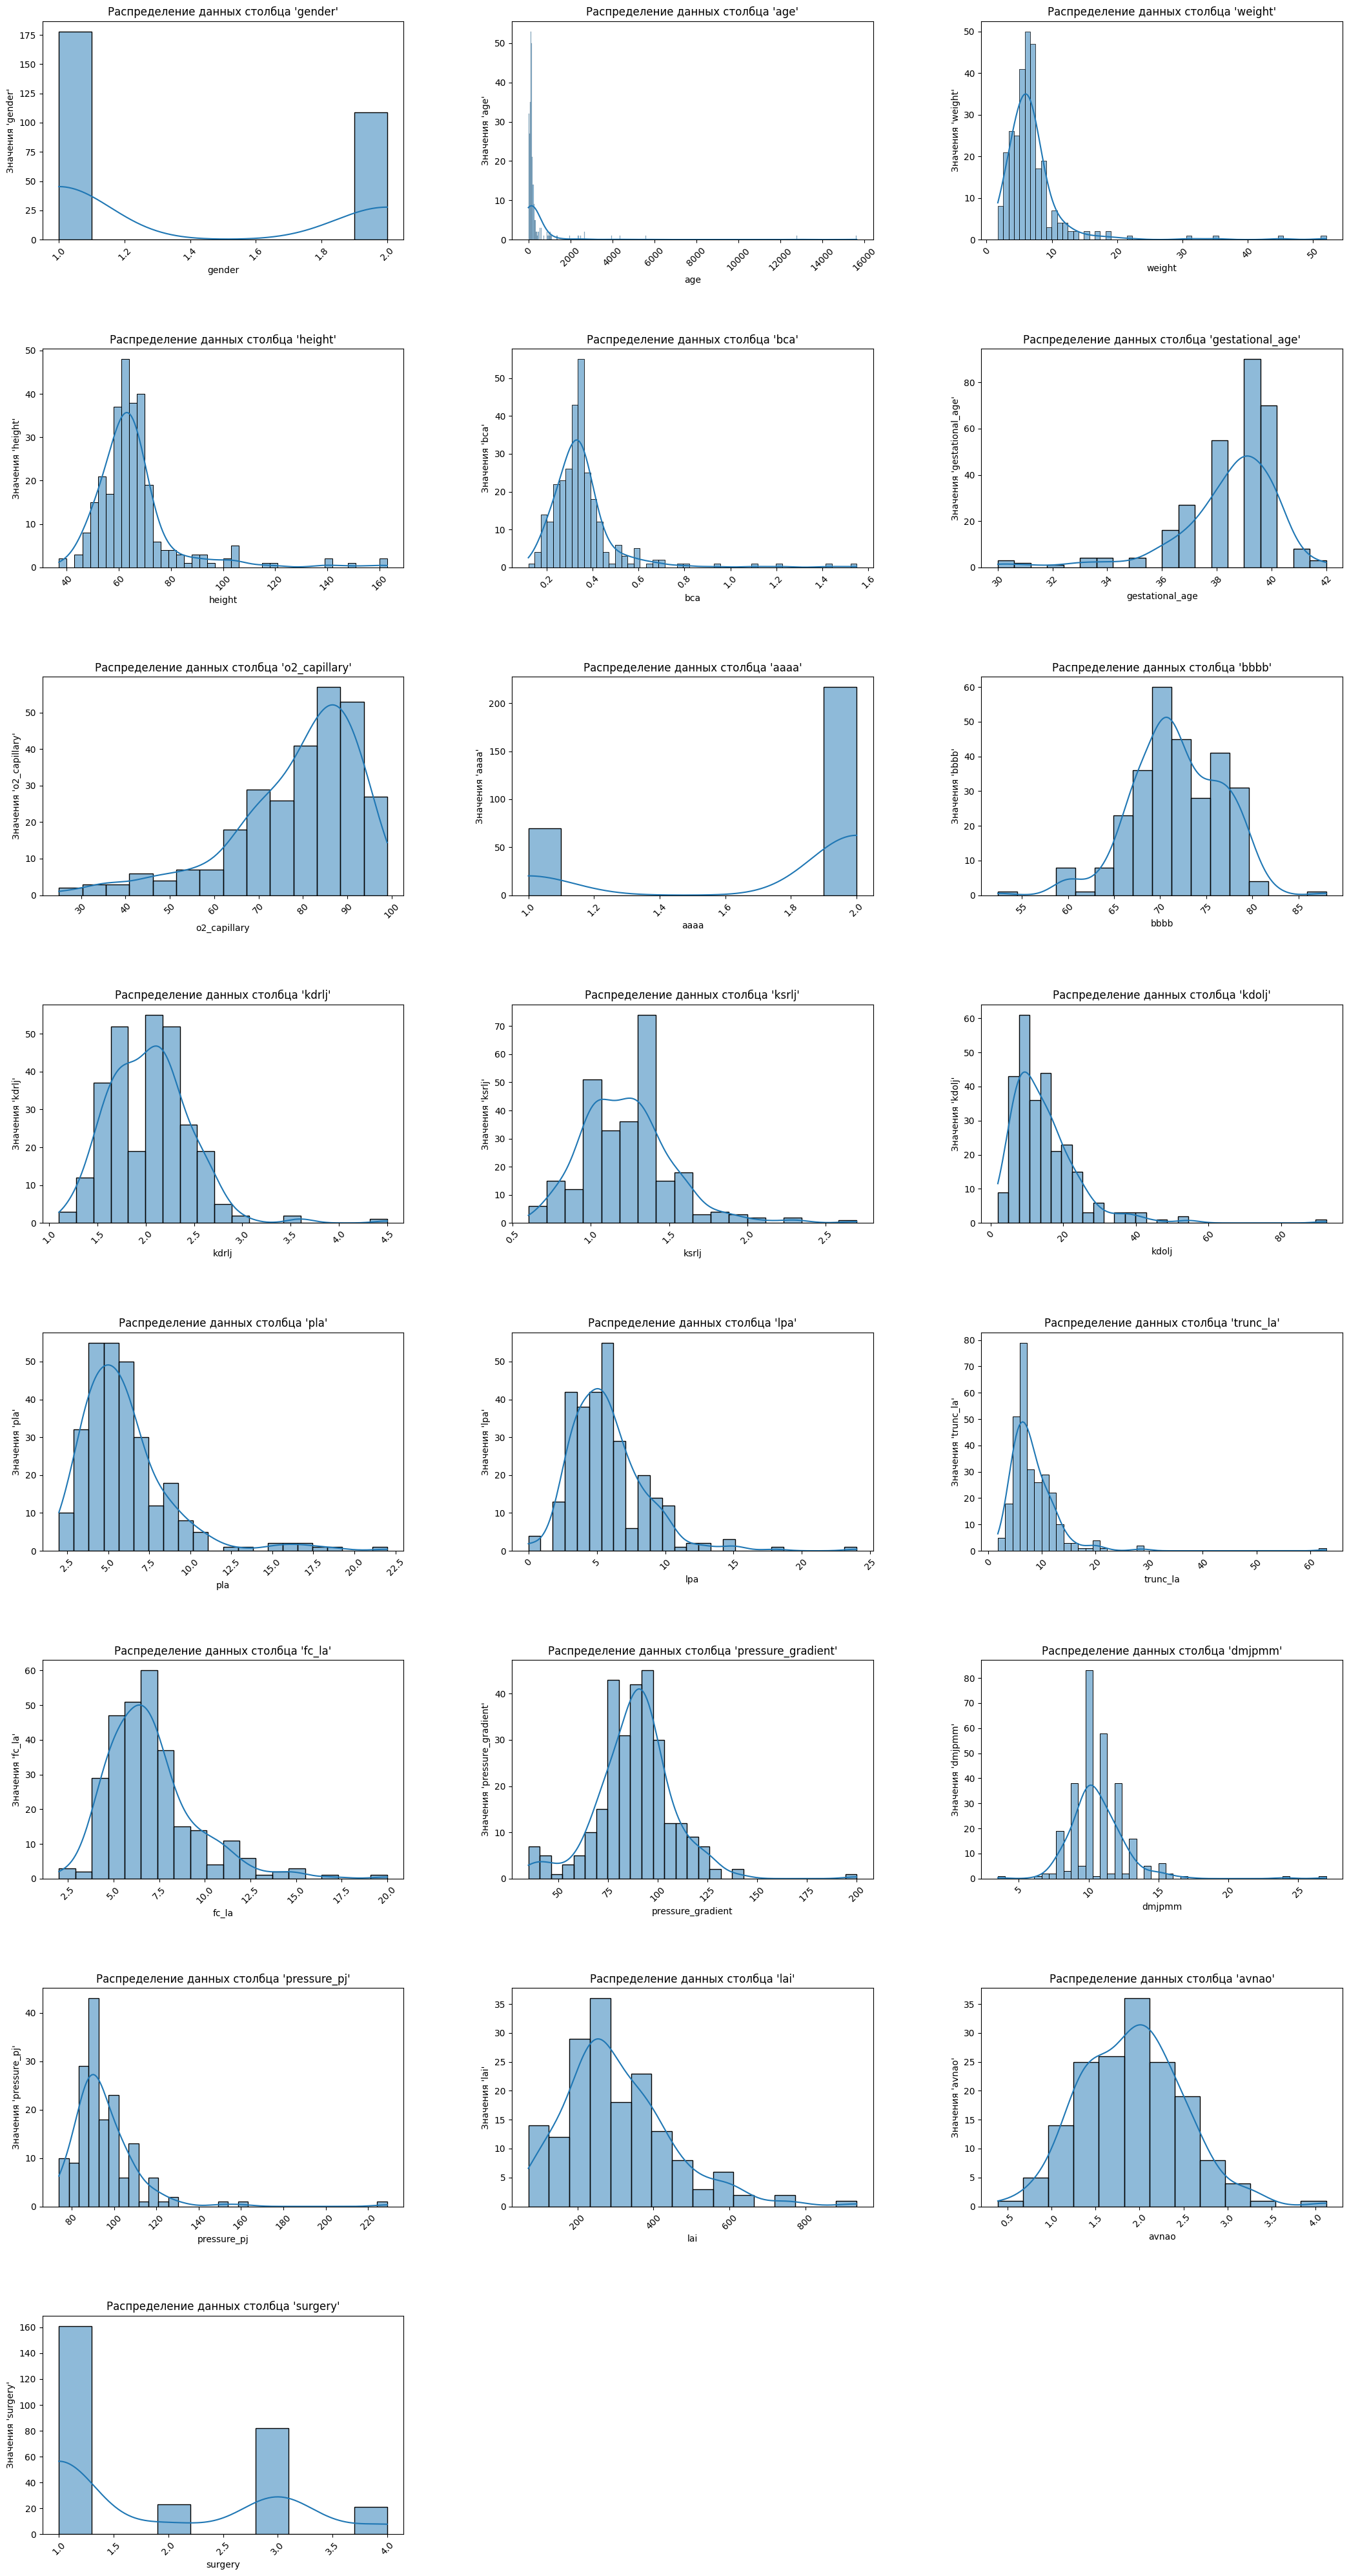

In [21]:
num_columns, cat_columns, num_df, cat_df  = divide_data_to_nums_and_cat_features(df)
plot_all_distributions(num_df)

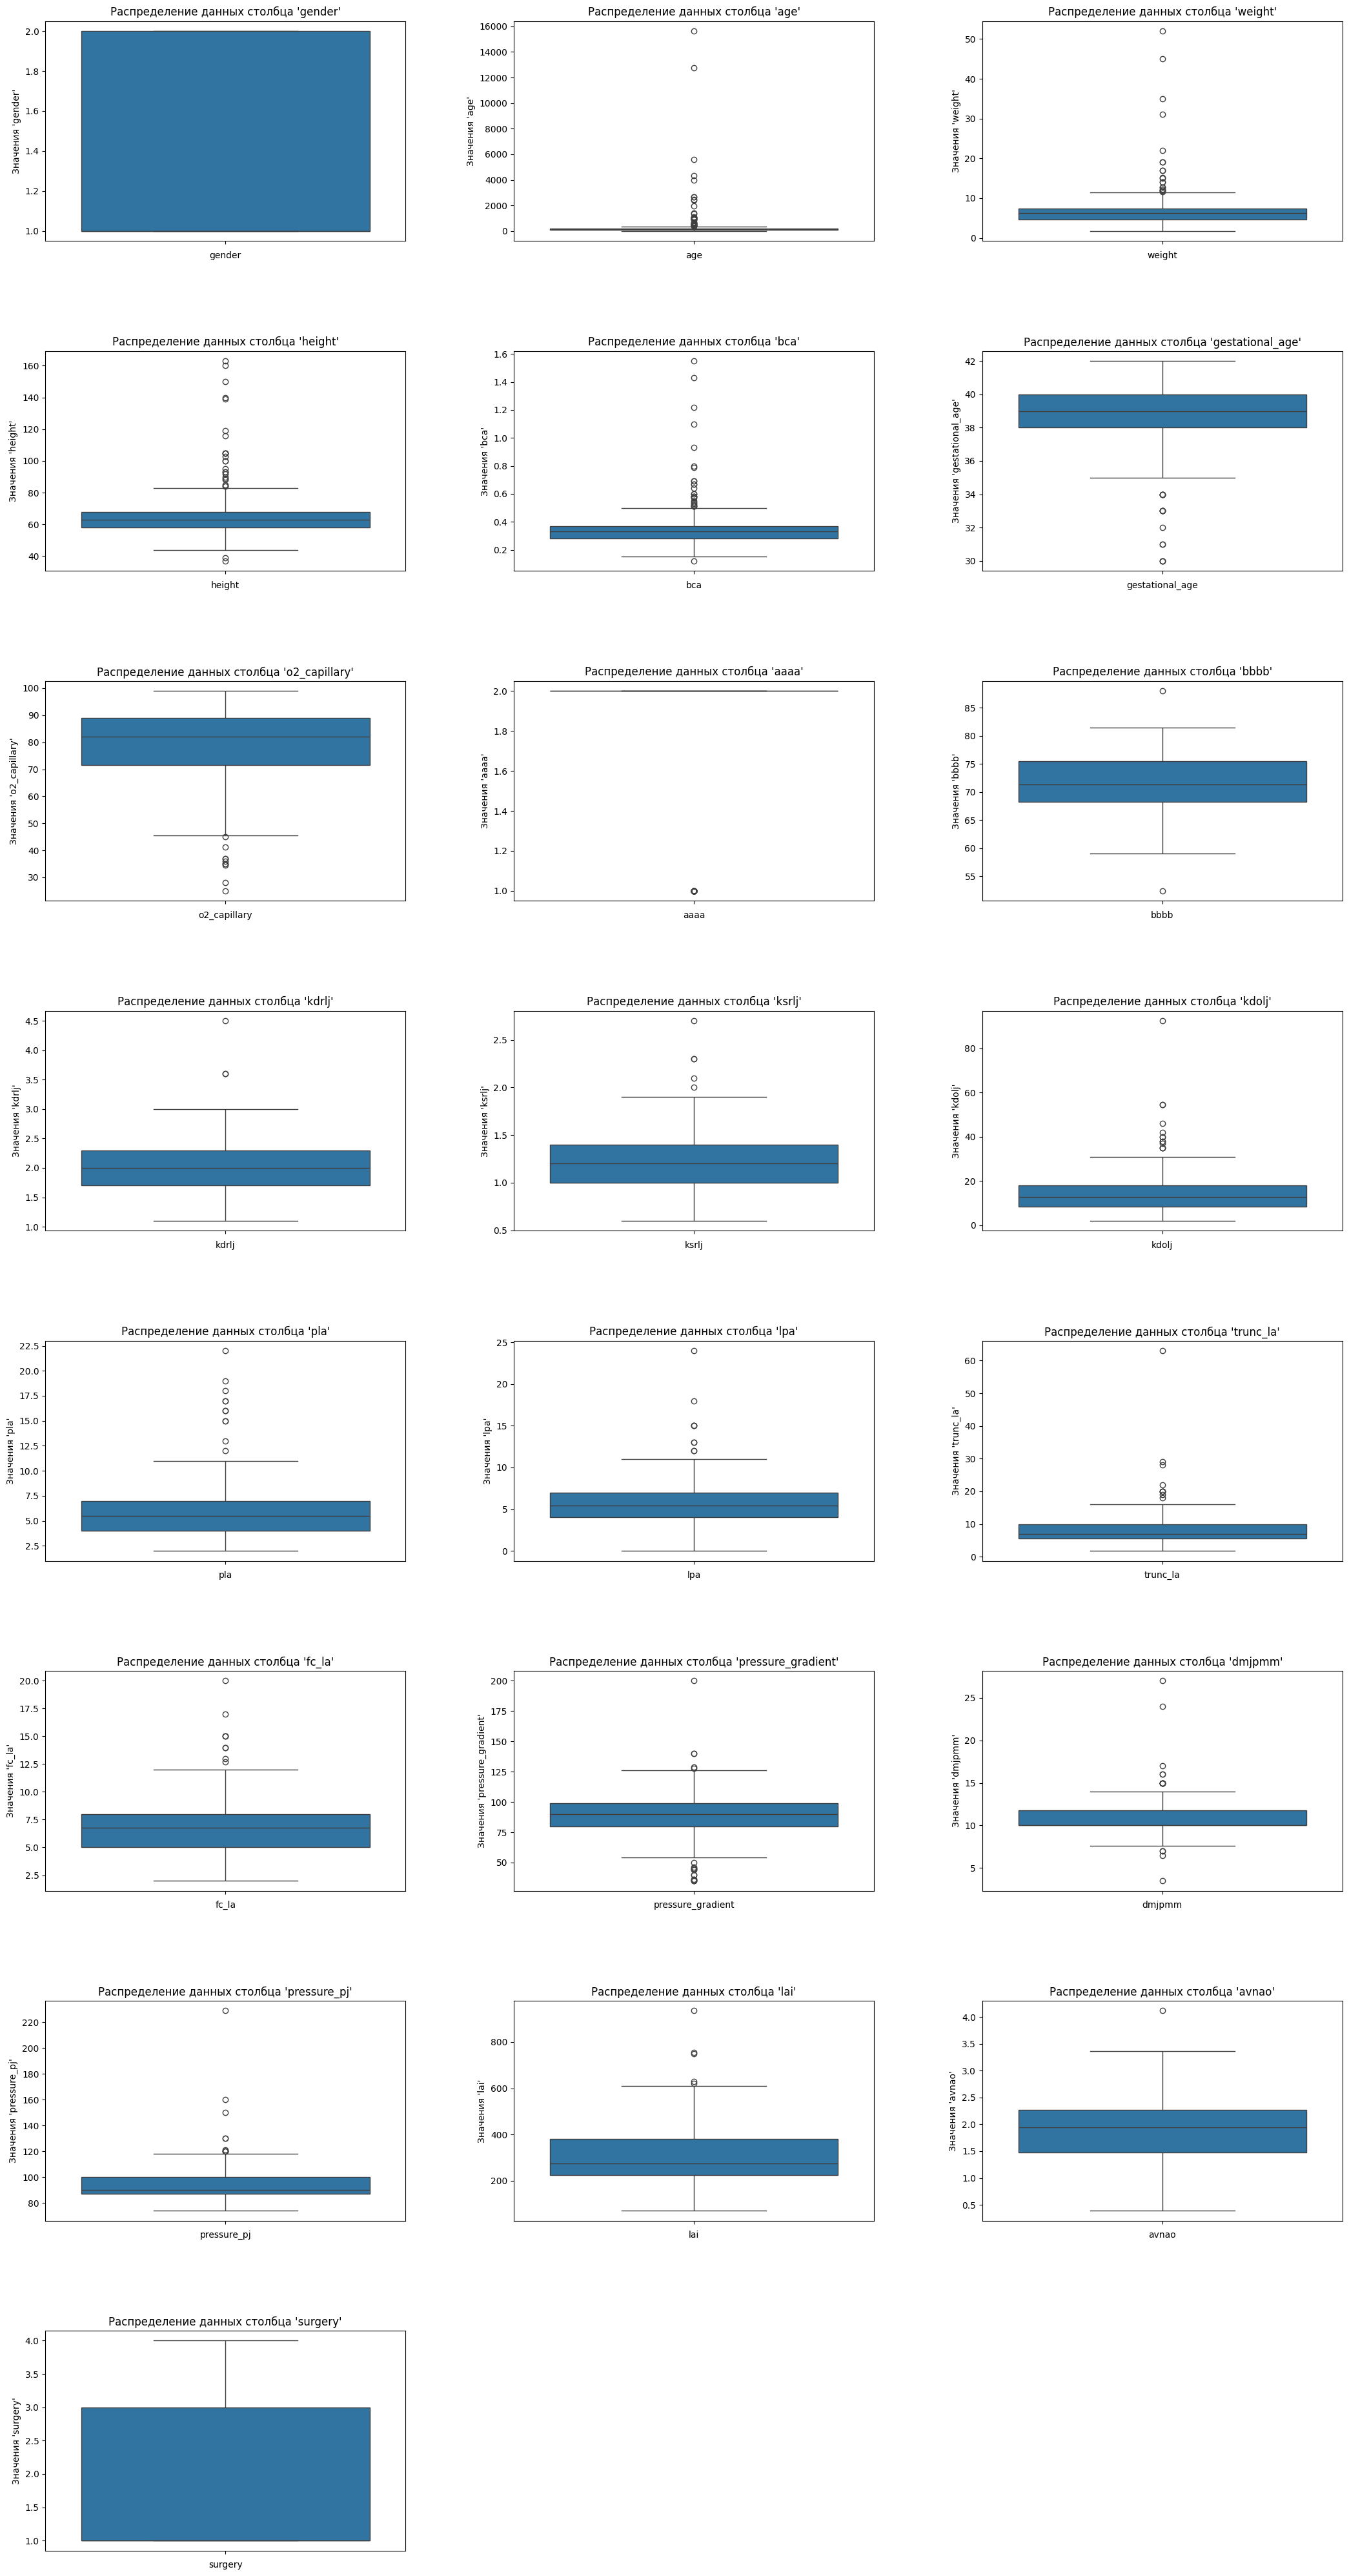

In [22]:
boxplot_all_distributions(num_df)

In [23]:
df.isnull().sum().sort_values(ascending=False)

pressure_pj          123
avnao                122
lai                  120
kdolj                 13
ksrlj                 12
pressure_gradient      5
o2_capillary           4
lpa                    2
kdrlj                  2
pla                    1
dmjpmm                 0
sashes_kl_la           0
fc_la                  0
trunc_la               0
gender                 0
age                    0
bbbb                   0
aaaa                   0
gestational_age        0
sopvps                 0
bca                    0
height                 0
weight                 0
surgery                0
dtype: int64

In [24]:
# оставим записи со значениями age < 5000
df = df.query('age < 5000')

Корреляционный анализ

interval columns not set, guessing: ['gender', 'age', 'weight', 'height', 'bca', 'gestational_age', 'o2_capillary', 'aaaa', 'bbbb', 'kdrlj', 'ksrlj', 'kdolj', 'pla', 'lpa', 'trunc_la', 'fc_la', 'pressure_gradient', 'dmjpmm', 'pressure_pj', 'lai', 'avnao', 'surgery']


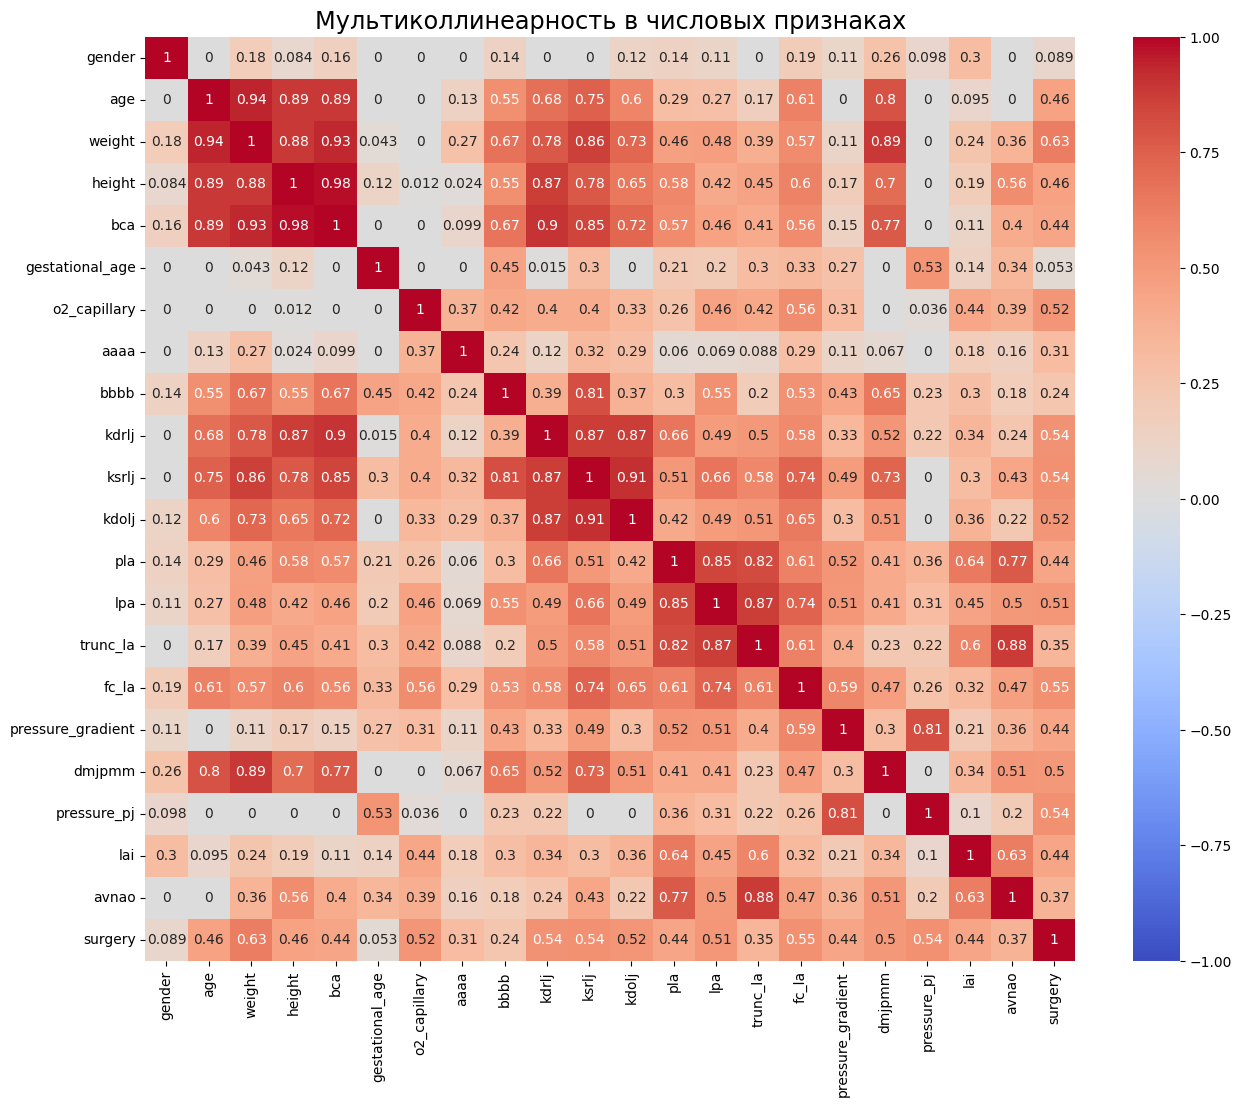

In [25]:
plt.figure(figsize=(15, 12))
sns.heatmap(df.loc[:, ~df.columns.isin(['sashes_kl_la', 'sopvps'])].phik_matrix(), annot=True, cmap='coolwarm', vmin=-1);
plt.title('Мультиколлинеарность в числовых признаках', fontsize='xx-large');
plt.show();

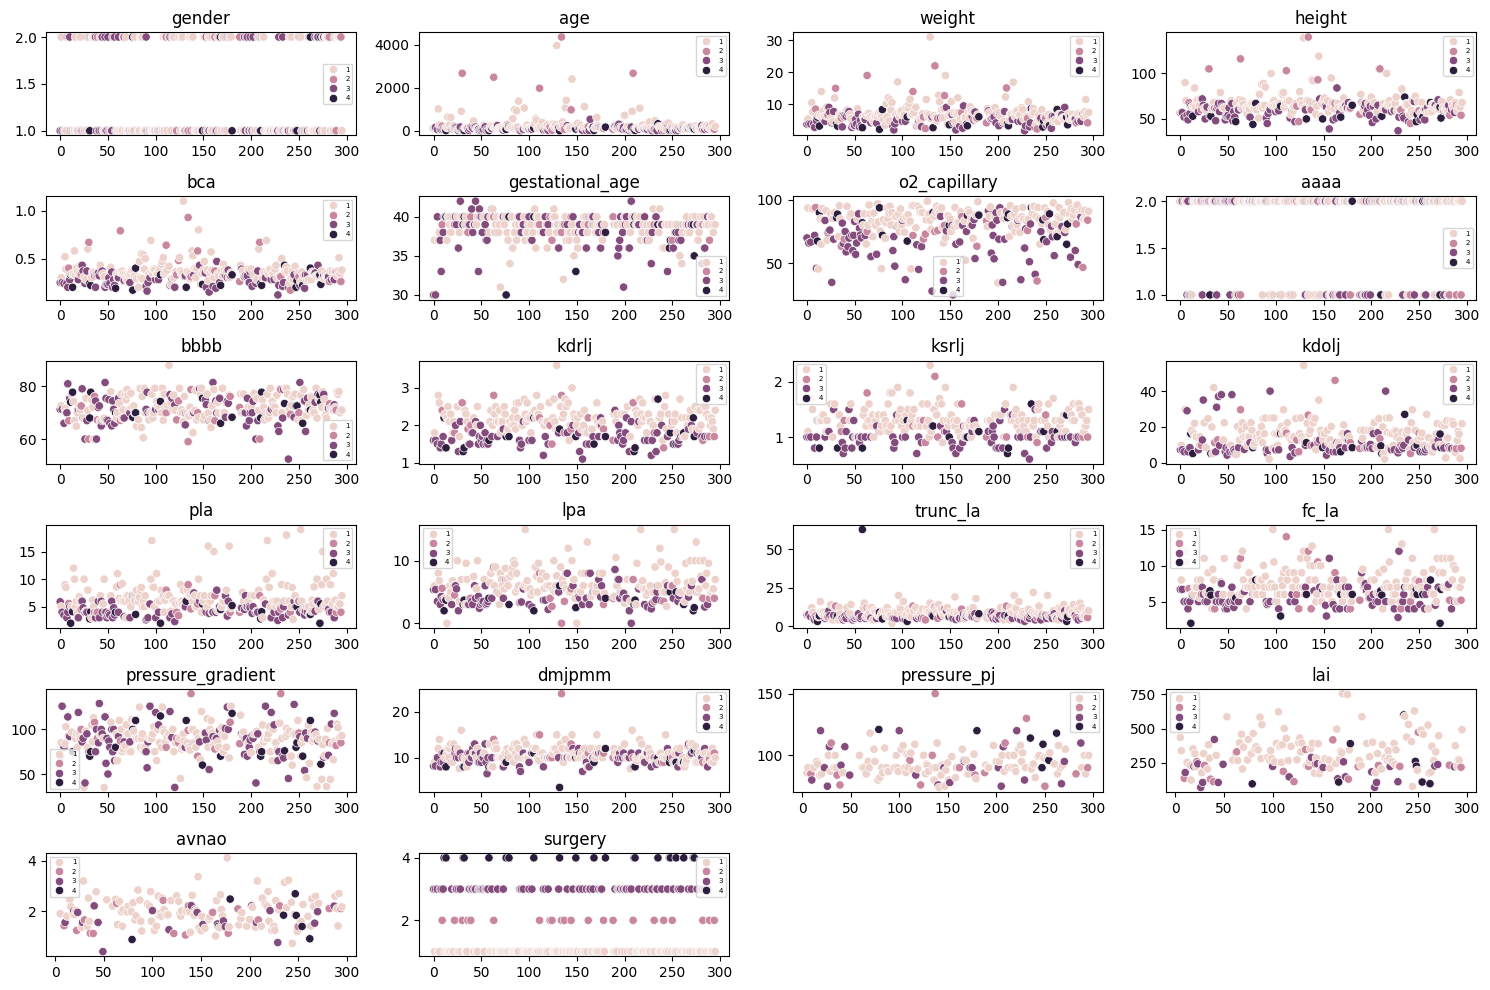

In [26]:
fig = plt.figure(figsize=(15,10))
for i, col in enumerate(df.loc[:, ~df.columns.isin(['sashes_kl_la', 'sopvps'])].columns):
    fig.add_subplot(6, 4, i+1)
    sns.scatterplot(x=df.index, y=df[col], hue=df['surgery']).set_title(col)
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(prop={'size':5})
    plt.tight_layout()

In [27]:
# Разделяем данные на train и test
X = df.drop('surgery', axis=1)
y = df['surgery']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(198, 23)
(86, 23)
(198,)
(86,)


In [28]:
# заменим значения в целевом признаке на 0,1,2,3
y_train = y_train.apply(lambda x: x-1)
y_test = y_test.apply(lambda x: x-1)
print(y_train.unique(), y_test.unique())

[0 3 1 2] [0 3 2 1]


In [29]:
numeric_features = X_train.drop(columns=['sashes_kl_la', 'sopvps', 'gender', 'aaaa'], axis=1).columns
categorial_features = ['sashes_kl_la', 'sopvps', 'gender', 'aaaa']

X_train[numeric_features] = X_train[numeric_features].astype(float)
X_train[categorial_features] = X_train[categorial_features].astype(str)

X_test[numeric_features] = X_test[numeric_features].astype(float)
X_test[categorial_features] = X_test[categorial_features].astype(str)

# Предобработка числовых признаков
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median", missing_values=np.nan)),
           ("scaler", MinMaxScaler())
          ]
)

# Предобработка категориальных признаков
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='most_frequent')),
           ("encoder", OneHotEncoder(handle_unknown="ignore"))
          ]
)

# Преобразование признаков
data_preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorial_features)
    ])

In [30]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [

    # словарь для модели DecisionTreeClassifier
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(2,5),
     'models__max_features': range(2,5)
    },

    # словарь для модели LogisticRegression
    {'models': [LogisticRegression(
        random_state=RANDOM_STATE,
        solver='newton-cg',
        multi_class='multinomial')],
     'models__C': range(1,5)
    },

        # словарь для модели RandomForestClassifier
    {'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
     'models__n_estimators': range(50, 150),
     'models__max_depth': range(2,5),
     'models__min_samples_split': range(2,5)
    }
]


gs = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['age', 'weight', 'height', 'bca', 'gestational_age', 'o2_capillary',
       'bbbb', 'kdrlj', 'ksrlj', 'kdolj', 'pla', 'lpa', 'trunc_la', 'fc_la',
       'pressure_gradient', 'dmjpmm', 'pressure_pj', 'lai', 'avnao'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequen

In [31]:
y_pred = gs.best_estimator_.predict(X_test)
print(f"Точность модали на тестовой выборке: {f1_score(y_test, y_pred, average='macro')}")

Точность модали на тестовой выборке: 0.5383405249910105


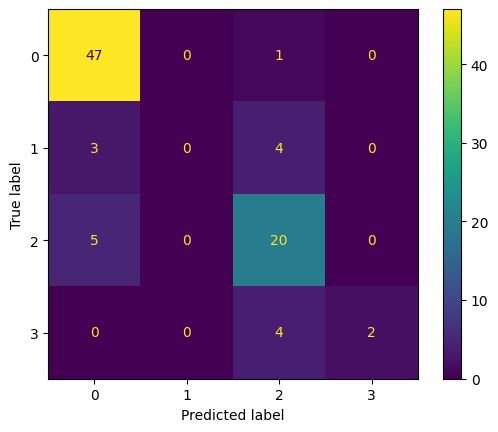

In [32]:
ConfusionMatrixDisplay.from_estimator(gs.best_estimator_, X_test, y_test)
plt.show() 

#### Вариант 2 (c imblearn)
Попробуем увеличить минорный класс с помощью RandomOverSampler и SMOTETomek

In [33]:
s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

numeric_transformer_imb = ImbPipeline(
    steps=[("scaler", StandardScaler()),
           ("imputer", SimpleImputer(strategy="median", missing_values=np.nan))
          ]
)

# Предобработка категориальных признаков
categorical_transformer_imb = ImbPipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
           ("imputer", SimpleImputer(strategy='most_frequent', missing_values=np.nan))
          ]
)

# Преобразование признаков
data_preprocessor_imb = ColumnTransformer([
        ('num', numeric_transformer_imb, numeric_features),
        ('cat', categorical_transformer_imb, categorial_features)
    ],
    remainder='passthrough')

#### DecisionTreeClassifier

In [34]:
dt_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor_imb),
    ('oversampler', RandomOverSampler(random_state=RANDOM_STATE)),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

dt_params = {
    'classifier__min_samples_leaf': [2, 4, 6, 8],
    'classifier__max_depth': [4, 6, 8, 10, 12],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__min_samples_split': [2, 5, 10]
}

gs_dt = GridSearchCV(
    dt_pipeline,
    dt_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_dt.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_dt.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_dt.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['age', 'weight', 'height', 'bca', 'gestational_age', 'o2_capillary',
       'bbbb', 'kdrlj', 'ksrlj', 'kdolj', 'pla', 'lpa', 'trunc_la', 'fc_la',
       'pressure_gradient', 'dmjpmm', 'pr...
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                       

In [35]:
y_pred_dt = gs_dt.best_estimator_.predict(X_test)
print(f"Точность модали на тестовой выборке: {f1_score(y_test, y_pred_dt, average='macro')}")

Точность модали на тестовой выборке: 0.6183780758248844


#### RandomForestClassifier

In [36]:
rf_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor_imb),
    ('oversampler', SMOTETomek(random_state=RANDOM_STATE)),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

rf_params = {
    'classifier__n_estimators': [25, 50, 75, 100],
    'classifier__min_samples_leaf': [2, 4, 6, 8],
    'classifier__max_depth': [6, 8, 10, 12],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__bootstrap': [True, False]
}

gs_rf = GridSearchCV(
    rf_pipeline,
    rf_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_rf.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_rf.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_rf.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['age', 'weight', 'height', 'bca', 'gestational_age', 'o2_capillary',
       'bbbb', 'kdrlj', 'ksrlj', 'kdolj', 'pla', 'lpa', 'trunc_la', 'fc_la',
       'pressure_gradient', 'dmjpmm', 'pr...
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                       

In [37]:
y_pred_rf = gs_rf.best_estimator_.predict(X_test)
print(f"Точность модали на тестовой выборке: {f1_score(y_test, y_pred_rf, average='macro')}")

Точность модали на тестовой выборке: 0.780650277557494


#### CatBoostClassifier

In [38]:
cb_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor_imb),
    ('oversampler', SMOTETomek(random_state=RANDOM_STATE)),
    ('classifier', CatBoostClassifier(loss_function='MultiClass'))
])

cb_params = {
     'classifier__iterations': [25, 50, 150],  
     'classifier__learning_rate': [0.1, 0.3, 0.5],
     'classifier__depth': [6, 8, 10, 12] 
}

gs_cb = GridSearchCV(
    cb_pipeline,
    cb_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_cb.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_cb.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_cb.best_score_)

0:	learn: 1.0361235	total: 205ms	remaining: 10s
1:	learn: 0.8258379	total: 272ms	remaining: 6.52s
2:	learn: 0.6781258	total: 324ms	remaining: 5.08s
3:	learn: 0.5809821	total: 375ms	remaining: 4.31s
4:	learn: 0.4970844	total: 423ms	remaining: 3.81s
5:	learn: 0.4277607	total: 496ms	remaining: 3.64s
6:	learn: 0.3788018	total: 558ms	remaining: 3.43s
7:	learn: 0.3365917	total: 620ms	remaining: 3.25s
8:	learn: 0.2973381	total: 680ms	remaining: 3.1s
9:	learn: 0.2659134	total: 739ms	remaining: 2.95s
10:	learn: 0.2426782	total: 797ms	remaining: 2.83s
11:	learn: 0.2201217	total: 855ms	remaining: 2.71s
12:	learn: 0.2018406	total: 910ms	remaining: 2.59s
13:	learn: 0.1847191	total: 970ms	remaining: 2.5s
14:	learn: 0.1699803	total: 1.03s	remaining: 2.41s
15:	learn: 0.1571299	total: 1.09s	remaining: 2.32s
16:	learn: 0.1444629	total: 1.15s	remaining: 2.24s
17:	learn: 0.1348068	total: 1.22s	remaining: 2.17s
18:	learn: 0.1259580	total: 1.28s	remaining: 2.08s
19:	learn: 0.1157442	total: 1.34s	remaining: 

In [39]:
y_pred_cb = gs_cb.best_estimator_.predict(X_test)
print(f"Точность модали на тестовой выборке: {f1_score(y_test, y_pred_cb, average='macro')}")

Точность модали на тестовой выборке: 0.766512444499103


#### LGBMClassifier

In [40]:
lgbm_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor_imb),
    ('oversampler', SMOTETomek(random_state=RANDOM_STATE)),
    ('classifier', LGBMClassifier(metric='multi_logloss', 
                                  random_state=RANDOM_STATE))
])

lgbm_params = {
     'classifier__learning_rate':[0.1, 0.03, 0.05],
     'classifier__num_leaves': [15, 20, 25, 30, 35],
     'classifier__max_depth': [2, 4, 6, 8, 10],
     'classifier__objective': ['multiclass', 'multiclassova'],
     'classifier__boosting': ['gbdt']
}

gs_lgbm = GridSearchCV(
    lgbm_pipeline,
    lgbm_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_lgbm.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_lgbm.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_lgbm.best_score_)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 110, number of negative: 332
[LightGBM] [Info] Number of positive: 110, number of negative: 332
[LightGBM] [Info] Number of positive: 111, number of negative: 331
[LightGBM] [Info] Number of positive: 111, number of negative: 331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2396
[LightGBM] [Info] Number of data points in the train set: 442, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.248869 -> initscore=-1.104655
[LightGBM] [Info] Start training from score -1.104655
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.248869 -> initscore=-1.104655
[LightGBM] [Inf

In [41]:
y_pred_lgbm = gs_lgbm.best_estimator_.predict(X_test)
print(f"Точность модали на тестовой выборке: {f1_score(y_test, y_pred_lgbm, average='macro')}")

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Точность модали на тестовой выборке: 0.7258142299290432


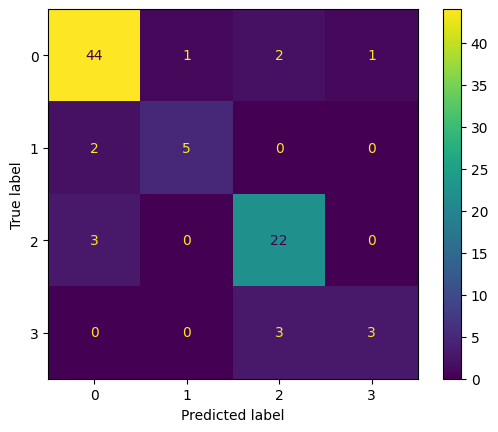

In [42]:
# получаем предсказания и строим матрицу ошибок
ConfusionMatrixDisplay.from_estimator(gs_rf.best_estimator_, X_test, y_test)
plt.show() 

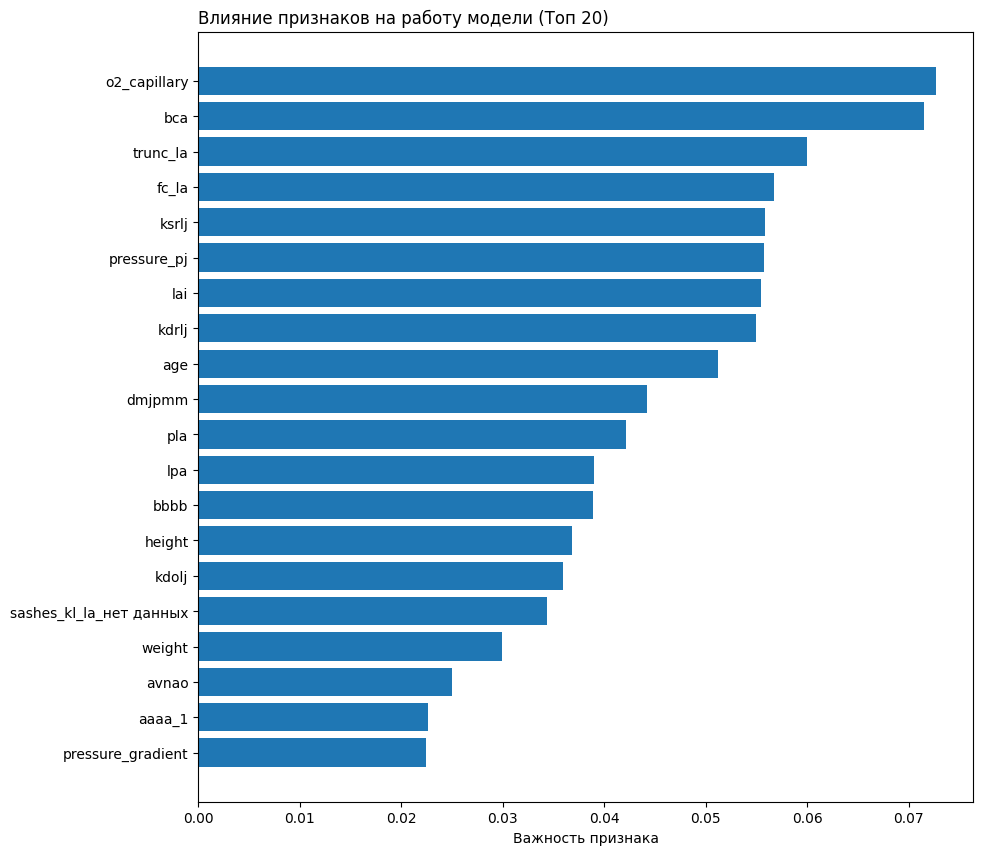

In [43]:
# Выводим график feature importance
column_names = gs_rf.best_estimator_.named_steps['preprocessor'].transformers_[1][1]\
                .get_feature_names_out(input_features=categorial_features)

feature_names = np.concatenate([numeric_features, column_names])

# Получение важности признаков из лучшего классификатора в пайплайне
importances = gs_rf.best_estimator_.named_steps['classifier'].feature_importances_

feature_importance(importances, feature_names)

#### Нейросеть

In [44]:
X_train_processed = data_preprocessor.fit_transform(X_train)
X_test_processed = data_preprocessor.transform(X_test)
seq_model = Sequential()
seq_model.add(Dense(40, activation = 'relu'))
seq_model.add(Dense(40, activation = 'relu'))
seq_model.add(Dense(4, activation = 'softmax'))

In [45]:
seq_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate= 1e-3), metrics = ['F1Score'])
seq_model.fit(X_train_processed, to_categorical(y_train.values), epochs = 30, batch_size = 5, validation_data=(X_test_processed, to_categorical(y_test.values)))
scores = seq_model.evaluate(X_test_processed, to_categorical(y_test.values))

for i, m in enumerate(seq_model.metrics_names):
    print(m, scores[i])

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - F1Score: 0.1344 - loss: 1.3976 - val_F1Score: 0.1791 - val_loss: 1.0443
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.1815 - loss: 1.0395 - val_F1Score: 0.1791 - val_loss: 0.9828
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.1996 - loss: 0.9993 - val_F1Score: 0.2011 - val_loss: 0.9486
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.2510 - loss: 0.9184 - val_F1Score: 0.3293 - val_loss: 0.9136
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.3376 - loss: 0.8735 - val_F1Score: 0.3267 - val_loss: 0.8728
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.3242 - loss: 0.8291 - val_F1Score: 0.3667 - val_loss: 0.8438
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.3573 - loss: 0.8900 - val_F1Score: 0.3743 - val_loss: 0.8288
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.3947 - loss: 0.8113 - val_F1Score: 0.3816 - val_loss: 0.8110
Epoch 9/

#### Нейросеть с oversampler 

In [46]:
# rvs = RandomOverSampler(random_state=RANDOM_STATE)
smt = SMOTETomek(random_state=RANDOM_STATE)
X_train_processed_smt, y_train_smt = smt.fit_resample(X_train_processed, y_train)

In [47]:
seq_model2 = Sequential()
seq_model2.add(Dense(10, activation = 'relu'))
seq_model2.add(Dense(20, activation = 'relu'))
seq_model2.add(Dense(30, activation = 'relu'))
seq_model2.add(Dropout(0.25))
seq_model2.add(Dense(4, activation = 'softmax'))
seq_model2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate= 1e-3), metrics = ['F1Score'])

seq_model2.fit(X_train_processed_smt, to_categorical(y_train_smt.values), epochs = 30, batch_size = 5, validation_data=(X_test_processed, to_categorical(y_test.values)))
scores = seq_model2.evaluate(X_test_processed, to_categorical(y_test.values))

for i, m in enumerate(seq_model2.metrics_names):
    print(m, scores[i])

Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - F1Score: 0.2878 - loss: 1.3908 - val_F1Score: 0.2425 - val_loss: 1.3640
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.3017 - loss: 1.3496 - val_F1Score: 0.2425 - val_loss: 1.3614
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.4059 - loss: 1.3090 - val_F1Score: 0.2973 - val_loss: 1.3474
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.5368 - loss: 1.1975 - val_F1Score: 0.3407 - val_loss: 1.2314
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.5908 - loss: 1.0897 - val_F1Score: 0.3799 - val_loss: 1.1763
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.5629 - loss: 1.0603 - val_F1Score: 0.4133 - val_loss: 1.0963
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.5957 - loss: 0.9650 - val_F1Score: 0.4376 - val_loss: 1.0478
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.6635 - loss: 0.8610 - val_F1Score: 0.4665 - val_loss: 0.9374
Epoch 9/

In [67]:
neu_preds2 = seq_model2.predict(X_test_processed)
neu_preds_cls2 = neu_preds2.argmax(axis=1)
neu_preds_cls2

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([1, 0, 1, 0, 3, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 0,
       2, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0, 2, 3, 2, 1, 2, 2, 0, 2, 0,
       0, 0, 1, 2, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 2, 0, 1, 1, 3, 0, 0,
       2, 1, 1, 2, 3, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 0, 0, 3, 0],
      dtype=int64)

In [68]:
print(f'Точность нейросети на тестовой выборке:\n{f1_score(y_test, neu_preds_cls2, average="macro")}')

Точность нейросети на тестовой выборке:
0.5573400542028283


#### Генерация новых признаков

In [48]:
df_fg = df.copy()

#df_fg['imt'] = df_fg['weight'] / ((df_fg['height'] / 100) ** 2)
df_fg['cavi'] = df_fg['ksrlj'] / df_fg['kdolj'] # индекс жесткости сосудов 
df_fg['olrf'] = df_fg['o2_capillary'] / df_fg['aaaa'] # уровень кислорода при дыхательной недостаточности 
df_fg['papi'] = df_fg['pressure_gradient'] / df['pressure_pj'] # Индекс давления в легочной артерии
df_fg['weight_age_ratio'] = df_fg['weight'] / df_fg['age'] # Соотношение веса к возрасту 
df_fg['heart_rate_index'] = df_fg['fc_la'] / df_fg['age'] # Индекс сердечного ритма 
df_fg['aaaa_age_ratio'] = df_fg['aaaa'] / df_fg['age'] # Соотношение УЛК к возрасту 

In [50]:
num_columns_fg, cat_columns_fg, num_df_fg, cat_df_fg  = divide_data_to_nums_and_cat_features(df_fg)

In [51]:
# Разделяем данные на train и test
W = df_fg.drop('surgery', axis=1)
z = df_fg['surgery']

W_train, W_test, z_train, z_test = train_test_split(W, z, test_size=TEST_SIZE, stratify=z, random_state=RANDOM_STATE)

print(W_train.shape)
print(W_test.shape)

print(z_train.shape)
print(z_test.shape)

(198, 29)
(86, 29)
(198,)
(86,)


In [52]:
df_fg['surgery'].unique()

array([3, 1, 2, 4], dtype=int64)

In [53]:
# заменим значения в целевом признаке на 0,1,2,3
z_train = z_train.apply(lambda x: x-1)
z_test = z_test.apply(lambda x: x-1)
print(z_train.unique(), z_test.unique())

[0 3 1 2] [0 3 2 1]


In [54]:
numeric_features_new = W_train.drop(columns=['sashes_kl_la', 'sopvps'], axis=1).columns
categorial_features_new = ['sashes_kl_la', 'sopvps']

W_train[numeric_features_new] = W_train[numeric_features_new].astype(float)
W_train[categorial_features_new] = W_train[categorial_features_new].astype(str)

new_numeric_transformer_imb = Pipeline(
    steps=[("scaler", StandardScaler()),
           ("imputer", SimpleImputer(strategy="median", missing_values=np.nan))
          ]
)

# Предобработка категориальных признаков
new_categorical_transformer_imb = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
           ("imputer", SimpleImputer(strategy='most_frequent'))
          ]
)

# Преобразование признаков
new_data_preprocessor_imb = ColumnTransformer([
        ('num', new_numeric_transformer_imb, numeric_features_new),
        ('cat', new_categorical_transformer_imb, categorial_features_new)
    ],
    remainder='passthrough')

In [55]:
cb_pipeline_new = ImbPipeline([
    ('preprocessor', new_data_preprocessor_imb),
    ('oversampler', SMOTETomek(random_state=RANDOM_STATE)),
    ('classifier', CatBoostClassifier(loss_function='MultiClass'))
])

cb_params = {
     'classifier__iterations': [25, 50, 150],  
     'classifier__learning_rate': [0.1, 0.3, 0.5],
     'classifier__depth': [6, 8, 10, 12] 
}

gs_cb_new = GridSearchCV(
    cb_pipeline_new,
    cb_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_cb_new.fit(W_train, z_train)

print('Лучшая модель и её параметры:\n\n', gs_cb_new.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_cb_new.best_score_)

0:	learn: 1.0745422	total: 21.3ms	remaining: 3.17s
1:	learn: 0.8945231	total: 44.6ms	remaining: 3.3s
2:	learn: 0.7330727	total: 57.7ms	remaining: 2.83s
3:	learn: 0.6321681	total: 70.5ms	remaining: 2.57s
4:	learn: 0.5319001	total: 83ms	remaining: 2.41s
5:	learn: 0.4793595	total: 96ms	remaining: 2.3s
6:	learn: 0.4410266	total: 108ms	remaining: 2.2s
7:	learn: 0.3908432	total: 120ms	remaining: 2.12s
8:	learn: 0.3480311	total: 132ms	remaining: 2.07s
9:	learn: 0.3158428	total: 145ms	remaining: 2.04s
10:	learn: 0.2855397	total: 159ms	remaining: 2s
11:	learn: 0.2541760	total: 173ms	remaining: 1.98s
12:	learn: 0.2334657	total: 190ms	remaining: 2s
13:	learn: 0.2175114	total: 201ms	remaining: 1.95s
14:	learn: 0.1949461	total: 213ms	remaining: 1.91s
15:	learn: 0.1802553	total: 225ms	remaining: 1.88s
16:	learn: 0.1677047	total: 237ms	remaining: 1.85s
17:	learn: 0.1580675	total: 254ms	remaining: 1.86s
18:	learn: 0.1517403	total: 268ms	remaining: 1.85s
19:	learn: 0.1428544	total: 281ms	remaining: 1.8

In [56]:
z_pred_cb_new = gs_cb_new.best_estimator_.predict(W_test)
print(f"Точность модали на тестовой выборке: {f1_score(z_test, z_pred_cb_new, average='macro')}")

Точность модали на тестовой выборке: 0.8169047619047618


In [57]:
rf_pipeline_new = ImbPipeline([
    ('preprocessor', new_data_preprocessor_imb),
    ('oversampler', SMOTETomek(random_state=RANDOM_STATE)),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

rf_params = {
    'classifier__n_estimators': [5, 25, 50, 75],
    'classifier__min_samples_leaf': [2, 4, 6, 8],
    'classifier__max_depth': [6, 8, 10, 12],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__bootstrap': [True, False]
}

gs_rf_new = GridSearchCV(
    rf_pipeline_new,
    rf_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_rf_new.fit(W_train, z_train)

print('Лучшая модель и её параметры:\n\n', gs_rf_new.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_rf_new.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['gender', 'age', 'weight', 'height', 'bca', 'gestational_age',
       'o2_capillary', 'aaaa', 'bbbb', 'kdrlj', 'ksrlj', 'kdolj', 'pla', 'lpa',
       'trunc_la', 'fc_la', 'pressure_gradie...
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                  

In [58]:
z_pred_rf = gs_rf_new.best_estimator_.predict(W_test)
print(f"Точность модали на тестовой выборке: {f1_score(z_test, z_pred_rf, average='macro')}")

Точность модали на тестовой выборке: 0.8594964314036477


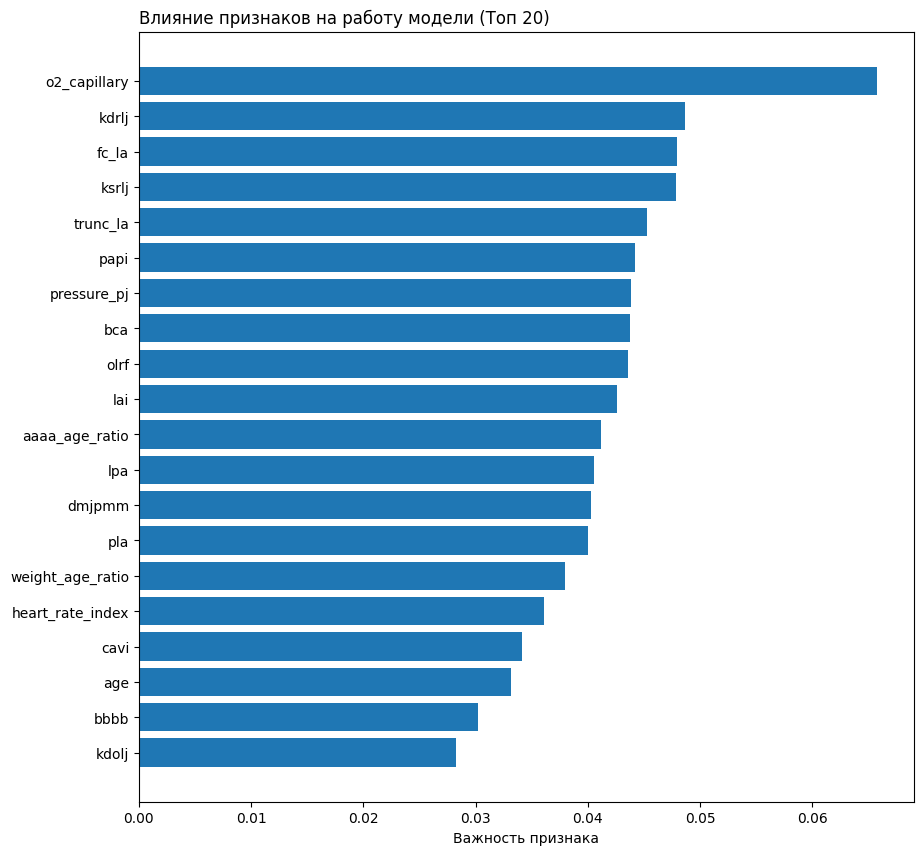

In [59]:
# Выводим график feature importance
column_names_new = gs_rf_new.best_estimator_.named_steps['preprocessor'].transformers_[1][1]\
                .get_feature_names_out(input_features=categorial_features_new)

feature_names_new = np.concatenate([numeric_features_new, column_names_new])

# Получение важности признаков из лучшего классификатора в пайплайне
importances_new = gs_rf_new.best_estimator_.named_steps['classifier'].feature_importances_

feature_importance(importances_new, feature_names_new)

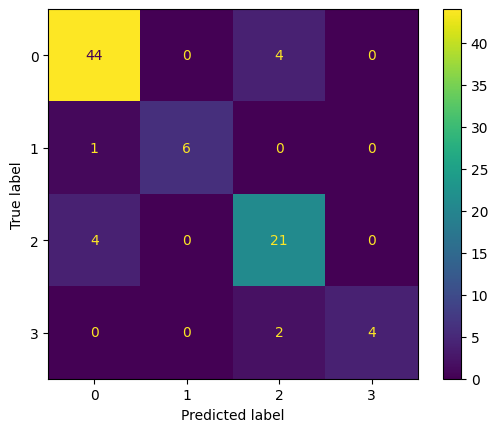

In [60]:
# получаем предсказания и строим матрицу ошибок
ConfusionMatrixDisplay.from_estimator(gs_rf_new.best_estimator_, W_test, z_test)
plt.show() 

#### Нейросеть с новыми признаками

In [61]:
W_train_processed = new_data_preprocessor_imb.fit_transform(W_train)
W_test_processed = new_data_preprocessor_imb.transform(W_test)

W_train_processed_smt, z_train_smt = smt.fit_resample(W_train_processed, z_train)

seq_model3 = Sequential()
seq_model3.add(Dense(10, activation = 'relu'))
seq_model3.add(Dropout(0.15))
seq_model3.add(Dense(20, activation = 'relu'))
seq_model3.add(Dropout(0.15))
seq_model3.add(Dense(30, activation = 'relu'))
seq_model3.add(Dropout(0.15))
seq_model3.add(Dense(4, activation = 'softmax'))
seq_model3.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate= 1e-3), metrics = ['F1Score'])

seq_model3.fit(W_train_processed_smt, to_categorical(z_train_smt.values), epochs = 30, batch_size = 5, validation_data=(W_test_processed, to_categorical(z_test.values)))
scores3 = seq_model3.evaluate(W_test_processed, to_categorical(z_test.values))

for i, m in enumerate(seq_model3.metrics_names):
    print(m, scores3[i])

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - F1Score: 0.2730 - loss: 1.3888 - val_F1Score: 0.4354 - val_loss: 1.2196
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.4342 - loss: 1.2752 - val_F1Score: 0.4613 - val_loss: 1.0654
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.4870 - loss: 1.1961 - val_F1Score: 0.5159 - val_loss: 0.9212
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.5428 - loss: 1.0239 - val_F1Score: 0.6029 - val_loss: 0.8130
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.5840 - loss: 0.9583 - val_F1Score: 0.5095 - val_loss: 0.7960
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.6256 - loss: 0.8955 - val_F1Score: 0.5371 - val_loss: 0.7751
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - F1Score: 0.7060 - loss: 0.7229 - val_F1Score: 0.5710 - val_loss: 0.6961
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.6794 - loss: 0.7391 - val_F1Score: 0.5970 - val_loss: 0.6708
Epoch 9

In [62]:
neu_preds = seq_model3.predict(W_test_processed)
neu_preds.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


(86, 4)

In [63]:
neu_preds_cls = neu_preds.argmax(axis=1)
neu_preds_cls

array([0, 0, 0, 0, 3, 0, 3, 0, 2, 0, 1, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 0,
       2, 0, 2, 0, 0, 1, 3, 1, 0, 0, 0, 2, 2, 2, 3, 2, 2, 2, 2, 0, 0, 0,
       0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 3, 0, 0,
       1, 0, 3, 2, 2, 0, 0, 0, 0, 2, 3, 2, 0, 0, 2, 2, 2, 0, 3, 0],
      dtype=int64)

In [64]:
print(f'Точность нейросети на тестовой выборке:\n{f1_score(z_test, neu_preds_cls, average="macro")}')

Точность нейросети на тестовой выборке:
0.7342053024155653


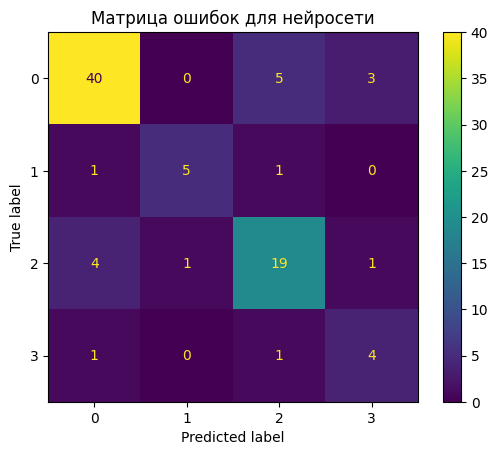

In [65]:
cm = confusion_matrix(z_test, neu_preds_cls)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot();
plt.title('Матрица ошибок для нейросети');

#### Результаты лучших моделей

In [66]:
print(f'Точность модели RF на тренировочной выборке:\n{gs_rf.best_score_}\n Лучшие гиперпараметры:\n{gs_rf.best_params_}')
print(f"Точность модели RF на тестовой выборке:\n{f1_score(y_test, y_pred_rf, average='macro')}")
print()
print()
print(f'Точность модели RF с новыми признаками на тренировочной выборке:\n{gs_rf_new.best_score_}\n Лучшие гиперпараметры:\n{gs_rf_new.best_params_}')
print(f"Точность RF c новыми признаками на тестовой выборке:\n{f1_score(z_test, z_pred_rf, average='macro')}")
print()
print()
print(f'Точность нейросети на тестовой выборке:\n{f1_score(z_test, neu_preds_cls, average="macro")}')

Точность модели RF на тренировочной выборке:
0.7118512173955024
 Лучшие гиперпараметры:
{'classifier__bootstrap': False, 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 75}
Точность модели RF на тестовой выборке:
0.780650277557494


Точность модели RF с новыми признаками на тренировочной выборке:
0.7226190722629207
 Лучшие гиперпараметры:
{'classifier__bootstrap': True, 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 75}
Точность RF c новыми признаками на тестовой выборке:
0.8594964314036477


Точность нейросети на тестовой выборке:
0.7342053024155653
